# 3.1 Machine Learning-Driven Image Segmentation using Data Clustering

This notebook implements image segmentation using K-means clustering. We'll follow a step-by-step approach to segment an image into distinct regions.

In [8]:
# Import required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import StandardScaler

## 3.1.1 Load Image
First, we'll create a function to load and display the image.

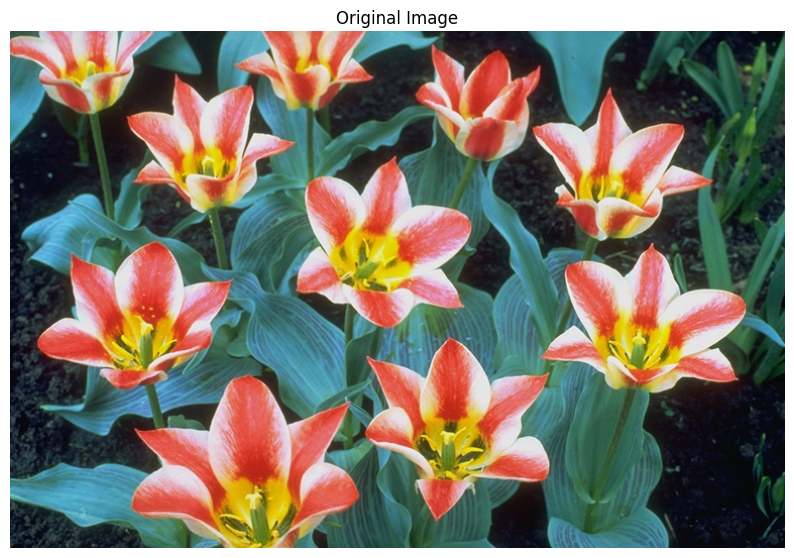

In [9]:
def load_image(path):
    """Load an image and convert it from BGR to RGB format."""
    img = cv2.imread(path)
    if img is not None:
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        raise FileNotFoundError(f"Could not load image from {path}")

# Load the image
image_path = "../part2/tulips.png"
image = load_image(image_path)

# Display the original image
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.show()

## 3.1.2 Preprocess Image
We'll create functions for common preprocessing operations.

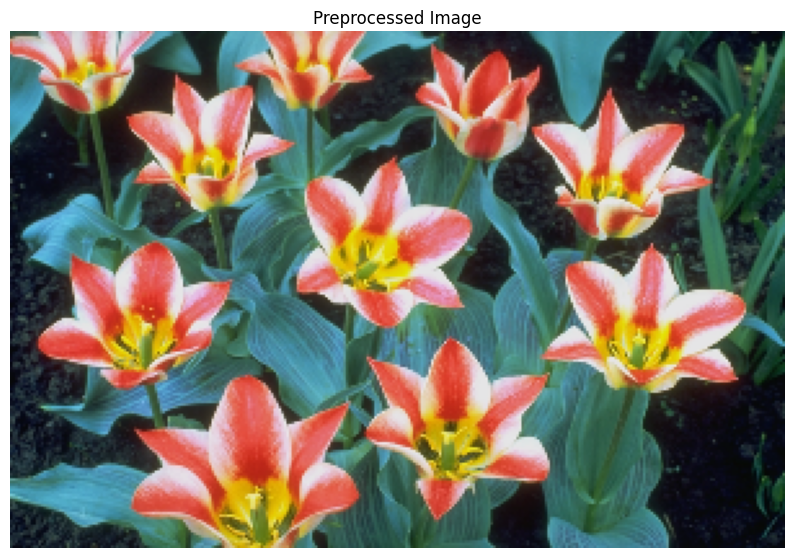

In [10]:
def preprocess_image(image, resize_dim=None, denoise=False):
    """Preprocess the image with optional resizing and denoising."""
    processed = image.copy()
    
    # Resize if dimensions are provided
    if resize_dim is not None:
        processed = cv2.resize(processed, resize_dim)
    
    # Apply denoising if requested
    if denoise:
        processed = cv2.fastNlMeansDenoisingColored(processed)
    
    return processed

# Preprocess the image (resize for faster processing)
preprocessed_image = preprocess_image(image, resize_dim=(300, 200))

plt.figure(figsize=(10, 8))
plt.imshow(preprocessed_image)
plt.title('Preprocessed Image')
plt.axis('off')
plt.show()

## 3.1.3 Convert Image to Feature Vectors
We'll prepare the image data for K-means clustering by converting it into feature vectors.

In [11]:
def prepare_features(image, feature_type='rgb'):
    """Convert image to feature vectors.
    
    Args:
        image: Input image
        feature_type: 'rgb' or 'position_rgb' to include pixel positions
    """
    height, width = image.shape[:2]
    
    if feature_type == 'rgb':
        # Reshape the image into a 2D array of pixels
        features = image.reshape((-1, 3))
    
    elif feature_type == 'position_rgb':
        # Create a grid of pixel positions
        y, x = np.mgrid[:height, :width]
        positions = np.column_stack((x.ravel(), y.ravel()))
        
        # Combine positions with RGB values
        colors = image.reshape((-1, 3))
        features = np.column_stack((positions, colors))
    
    # Scale features to have zero mean and unit variance
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    return features_scaled, features, scaler

# Prepare features
features_scaled, features_original, scaler = prepare_features(preprocessed_image, 'rgb')
print(f"Feature shape: {features_scaled.shape}")

Feature shape: (60000, 3)


## 3.1.4-3.1.7 K-means Clustering and Segmentation
Now we'll implement the K-means clustering and create the segmented image.

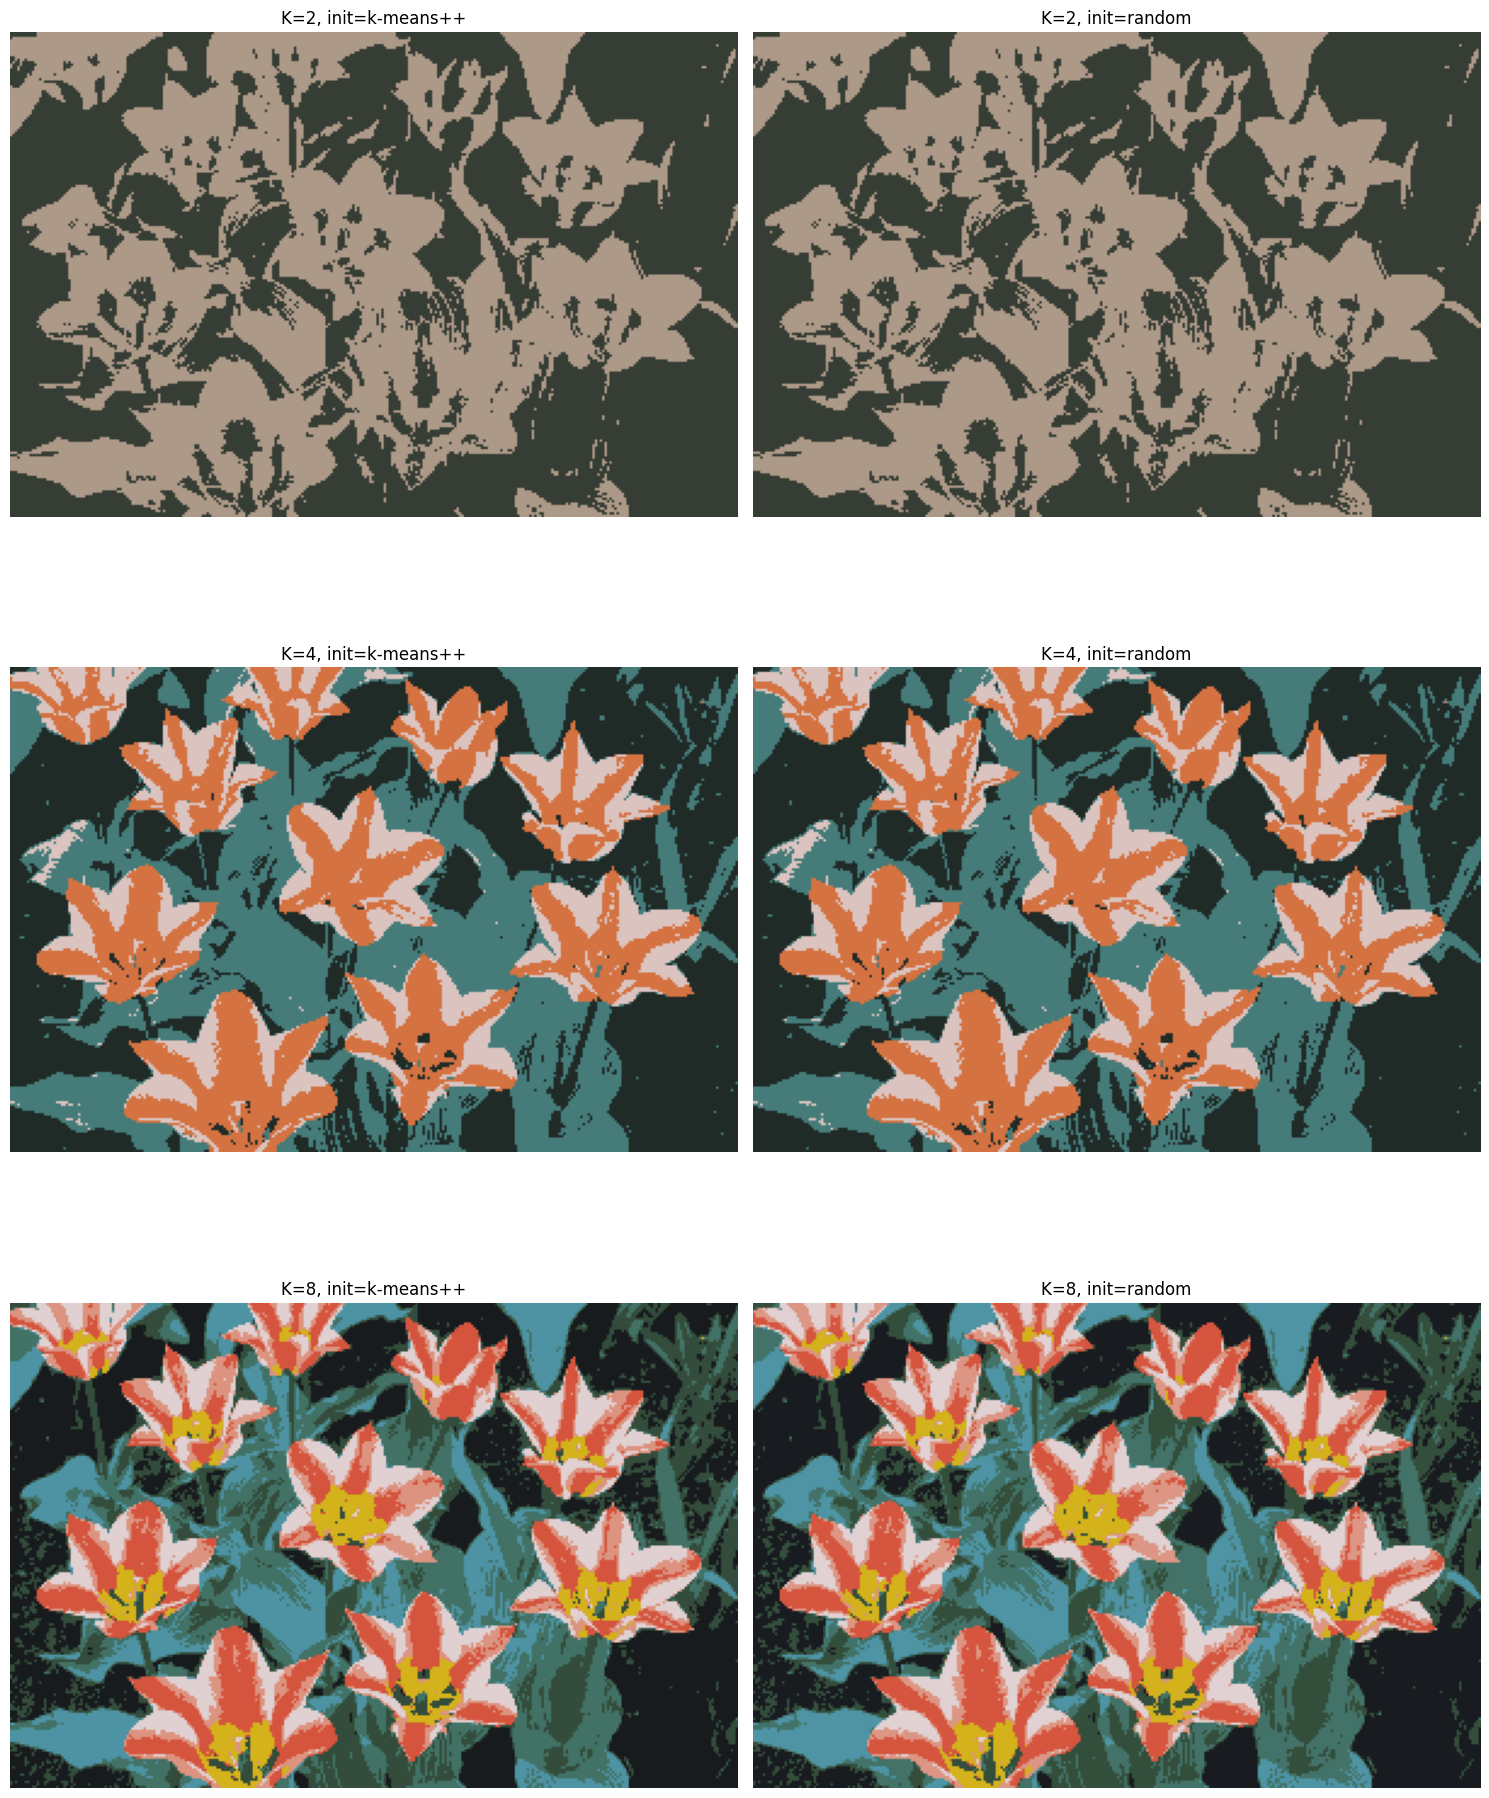

In [12]:
def apply_kmeans(features, n_clusters, init_method='k-means++', metric='euclidean'):
    """Apply K-means clustering to the features."""
    kmeans = KMeans(n_clusters=n_clusters, init=init_method, n_init=10, random_state=42)
    labels = kmeans.fit_predict(features)
    centroids = kmeans.cluster_centers_
    
    return labels, centroids

def create_segmented_image(image, labels, centroids):
    """Create segmented image by replacing pixels with their cluster centroids."""
    # Map each pixel to its centroid
    segmented = centroids[labels].reshape(image.shape)
    
    # Ensure values are in valid range [0, 255]
    segmented = np.clip(segmented, 0, 255).astype(np.uint8)
    
    return segmented

# Test different numbers of clusters
n_clusters_list = [2, 4, 8]
init_methods = ['k-means++', 'random']

fig, axes = plt.subplots(len(n_clusters_list), len(init_methods), figsize=(15, 20))

for i, n_clusters in enumerate(n_clusters_list):
    for j, init_method in enumerate(init_methods):
        # Apply K-means
        labels, centroids = apply_kmeans(features_scaled, n_clusters, init_method)
        
        # Create segmented image
        segmented = create_segmented_image(preprocessed_image, 
                                          labels, 
                                          scaler.inverse_transform(centroids))
        
        # Display results
        axes[i, j].imshow(segmented)
        axes[i, j].set_title(f'K={n_clusters}, init={init_method}')
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

## 3.1.8 Save Segmented Image
Let's save our best segmentation result.

In [13]:
def save_segmented_image(image, filename):
    """Save the segmented image to a file."""
    # Convert RGB to BGR for OpenCV
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(filename, image_bgr)
    print(f"Image saved as {filename}")

# Get the best segmentation (k=4, k-means++)
best_labels, best_centroids = apply_kmeans(features_scaled, n_clusters=4, init_method='k-means++')
best_segmented = create_segmented_image(preprocessed_image, 
                                       best_labels, 
                                       scaler.inverse_transform(best_centroids))

# Save the result
save_segmented_image(best_segmented, 'segmented_tulips.png')

Image saved as segmented_tulips.png


## 3.1.9 Additional Experimentation
Let's try different distance metrics and visualize their effects.

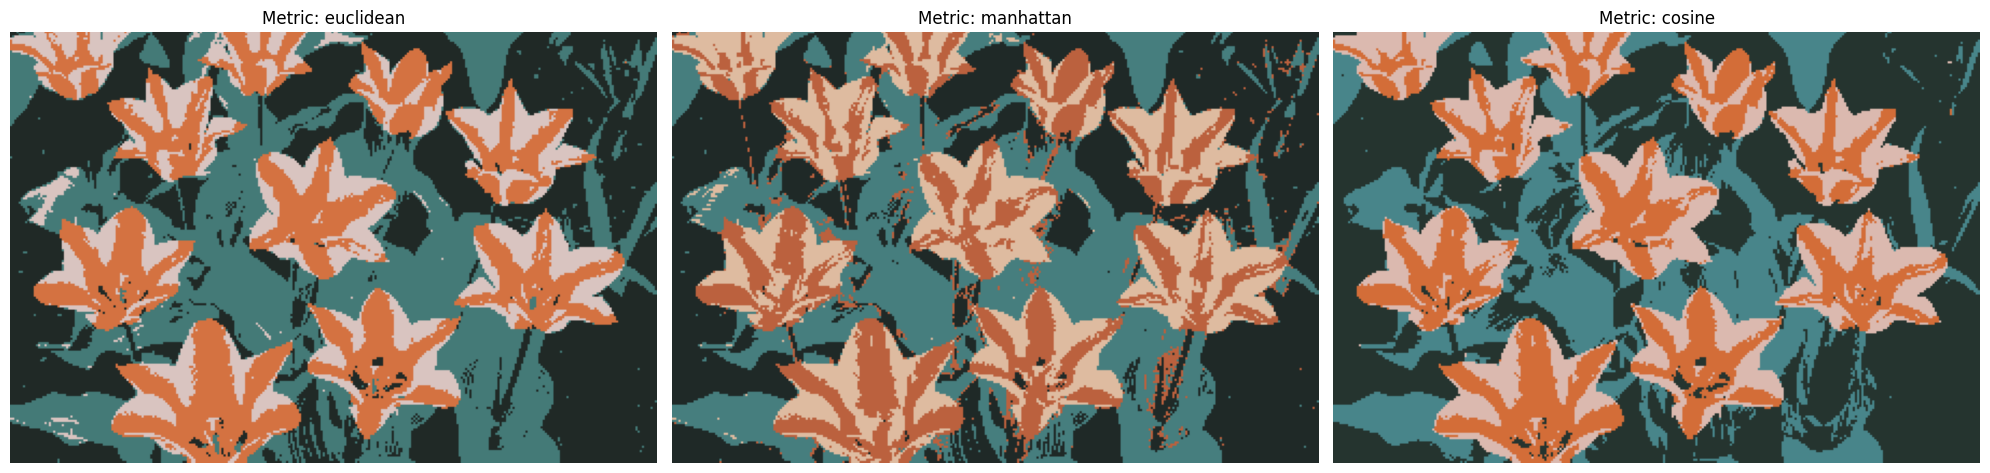

In [14]:
def segment_with_custom_distance(features, n_clusters, metric):
    """Segment image using K-means with custom distance metric."""
    # Initialize centroids randomly
    n_samples = features.shape[0]
    random_state = np.random.RandomState(42)
    indices = random_state.permutation(n_samples)[:n_clusters]
    centroids = features[indices]
    
    for _ in range(10):  # Max iterations
        # Assign points to nearest centroid
        distances = pairwise_distances(features, centroids, metric=metric)
        labels = distances.argmin(axis=1)
        
        # Update centroids
        new_centroids = np.array([features[labels == k].mean(axis=0)
                                 for k in range(n_clusters)])
        
        if np.all(centroids == new_centroids):
            break
            
        centroids = new_centroids
    
    return labels, centroids

# Test different metrics
metrics = ['euclidean', 'manhattan', 'cosine']
n_clusters = 4

fig, axes = plt.subplots(1, len(metrics), figsize=(20, 6))

for i, metric in enumerate(metrics):
    labels, centroids = segment_with_custom_distance(features_scaled, n_clusters, metric)
    segmented = create_segmented_image(preprocessed_image, 
                                      labels, 
                                      scaler.inverse_transform(centroids))
    
    axes[i].imshow(segmented)
    axes[i].set_title(f'Metric: {metric}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()